In [1]:
import json
import pandas as pd

讀取資料

In [2]:
with open('../data/output_clean_date_technical.json', 'r') as file:
    data = json.load(file)

攤平資料

In [3]:
merged_dict = {}

for item in data:
  if item == "historicalPriceFull":
    symbol = ""
    for entry in data[item]:
        if "symbol" in entry:
            symbol = data[item][entry]
        else:
            df = pd.json_normalize(data[item][entry])
            df["symbol"] = symbol
  else:
     df = pd.json_normalize(data[item])
  
  merged_dict[item] = df

In [4]:
merged_dict.keys()

dict_keys(['financialGrowth', 'ratios', 'cashFlowStatementGrowth', 'incomeStatementGrowth', 'balanceSheetStatementGrowth', 'historicalPriceFull', 'tech5', 'tech20', 'tech60', 'tech252'])

In [5]:
for k,v in merged_dict.items():
  print(k)
  print(v.head())

financialGrowth
    symbol        date calendarYear period  revenueGrowth  grossProfitGrowth  \
0  1101.TW  2023-10-30         2023     Q3      -0.024069          -0.035089   
1  1101.TW  2023-07-30         2023     Q2       0.052187           1.423824   
2  1101.TW  2023-04-30         2023     Q1      -0.241216          -0.523558   
3  1101.TW  2023-01-31         2022     Q4       0.113496           1.021971   
4  1101.TW  2022-10-30         2022     Q3       0.236128          22.238472   

   ebitgrowth  operatingIncomeGrowth  netIncomeGrowth  epsgrowth  ...  \
0   -0.181537              -0.181537        -0.647973  -0.622222  ...   
1    2.241177               2.241177         2.522023   2.214286  ...   
2   -0.571776              -0.571776        -0.595665  -0.611111  ...   
3    0.482921               0.482921         0.647513   0.636364  ...   
4    7.563693               7.563693         2.604780   2.571429  ...   

   tenYDividendperShareGrowthPerShare  fiveYDividendperShareGrow

將tech指數合併

In [ ]:
tech_merged_df = pd.DataFrame()
for k, v in merged_dict.items():
    if k.startswith("tech"):
        v["symbol"] = k
        tech_merged_df = pd.concat([tech_merged_df, v])
merged_dict["techIndex"] = tech_merged_df

In [ ]:
for k,v in merged_dict.items():
  print(k)
  print(v.head())

---

## 時間序列

使用過去股價，預設之後股價

In [6]:
merged_dict["historicalPriceFull"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              736 non-null    object 
 1   open              736 non-null    float64
 2   high              736 non-null    float64
 3   low               736 non-null    float64
 4   close             736 non-null    float64
 5   adjClose          736 non-null    float64
 6   volume            736 non-null    int64  
 7   unadjustedVolume  736 non-null    int64  
 8   change            736 non-null    float64
 9   changePercent     736 non-null    float64
 10  vwap              736 non-null    float64
 11  label             736 non-null    object 
 12  changeOverTime    736 non-null    float64
 13  symbol            736 non-null    object 
dtypes: float64(9), int64(2), object(3)
memory usage: 80.6+ KB


### prophet
https://github.com/facebook/prophet

code reference: https://medium.com/@aamurtazin/predicting-stock-market-with-python-3ce9fcbe23b2

In [8]:
historical_df = merged_dict["historicalPriceFull"]

In [23]:
from typing import List

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df = df[["date", "close"]]
    df.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)
    return df

def split_data(df: pd.DataFrame, test_size: float = 0.2) -> List[pd.DataFrame]:
    df = df.sort_values(by="ds", ascending=True).reset_index(drop=True)
    train_df = df.iloc[:int(len(df) * (1 - test_size))]
    test_df = df.iloc[int(len(df) * (1 - test_size)):]
    return train_df, test_df

In [24]:
df = preprocess_data(historical_df)
train_df, test_df = split_data(df)
print(f"training data size: {len(train_df)}, test data size: {len(test_df)}")

training data size: 588, test data size: 148


/tmp/ipykernel_651454/2923959088.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)


In [6]:
from prophet import Prophet

/home/ya/Practice/test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [10]:
def train_prophet_model(data):
    model = Prophet(
        changepoint_prior_scale=0.05,
        holidays_prior_scale=15,
        seasonality_prior_scale=10,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )
    model.add_country_holidays(country_name='TW')
    model.fit(data)
    return model

def generate_forecast(model, periods=365):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

def plot_forecast(model, forecast):
    model.plot(forecast)

12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing
/home/ya/Practice/test/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ya/Practice/test/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


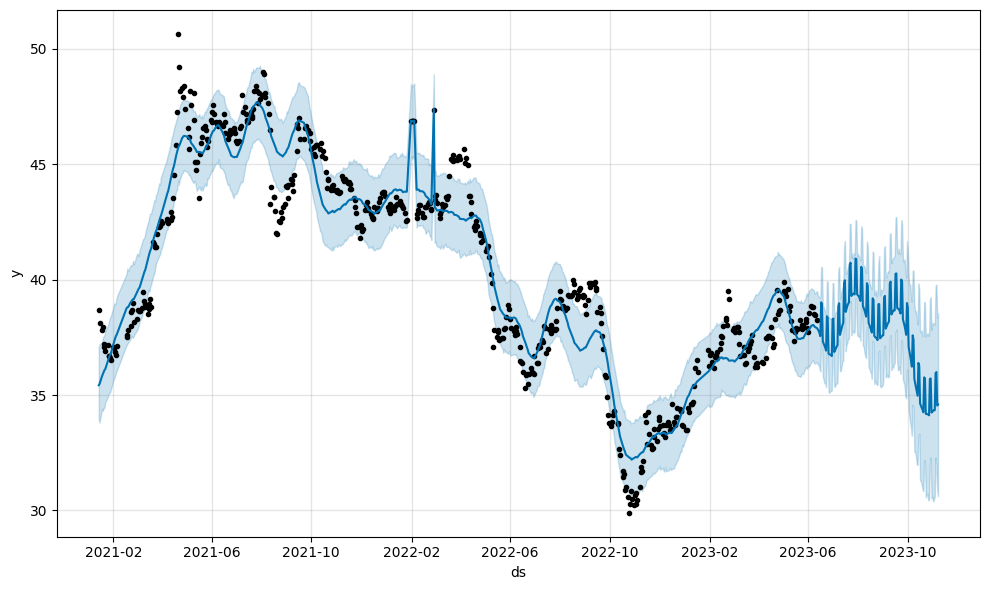

In [25]:
model = train_prophet_model(train_df)
forecast = generate_forecast(model, len(test_df))
plot_forecast(model, forecast)

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def compute_rmse(test_df: pd.DataFrame, forecast: pd.DataFrame) -> float:
    rmse = sqrt(mean_squared_error(test_df["y"], forecast["yhat"][:len(test_df)]))
    return rmse

In [31]:
rmse = compute_rmse(test_df, forecast)
print(rmse)

10.282387860407976
